<a href="https://colab.research.google.com/github/MProuts/deep_learning/blob/main/chapter_2/notebook_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Grab API key from google drive
# ==============================

# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# 
# # Authenticate and create the PyDrive client.
# # This only needs to be done once per notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# 
# # Download a file based on its file ID.
# # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
# file_id = '1cNg43o1nDnvoc3sVWm2SpGKXZSQ2EQVV'
# downloaded = drive.CreateFile({'id': file_id})
# key = downloaded.GetContentString().rstrip()

In [2]:
# Book-specific setup
# ===================
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 719 kB 26.8 MB/s 
     |████████████████████████████████| 4.7 MB 57.7 MB/s 
     |████████████████████████████████| 1.3 MB 58.3 MB/s 
     |████████████████████████████████| 365 kB 73.7 MB/s 
     |████████████████████████████████| 120 kB 72.2 MB/s 
     |████████████████████████████████| 115 kB 73.0 MB/s 
     |████████████████████████████████| 212 kB 63.9 MB/s 
     |████████████████████████████████| 127 kB 69.2 MB/s 
     |████████████████████████████████| 6.6 MB 58.3 MB/s 
Mounted at /content/gdrive


In [22]:
imageURLs = search_images_ddg('brussels griffon dog')
print(imageURLs)
len(imageURLs)

['https://lh5.googleusercontent.com/proxy/hcAQIaw0avmeSKzg_MH06lR8-BDCERJxB1DNYxYgbN8xslqWFQ1h07NoTgOKLfEvy5Ny13yI9Xyyxon2GUHY4gCRAxr3_cHfu9DmwU3E534pm-JYosIXRltLrezmOcJti9nG79_NqJcG-Q=s0-d', 'https://doggiefetch.com/wp-content/uploads/2018/05/Brussel-Griffon-Dog-Breed-min.jpg', 'https://www.europuppy.com/wp-content/uploads/2018/04/KALO16brg180208_F1_24.jpg', 'https://www.holistapet.com/wp-content/uploads/2020/10/brussels-griffon-health.png', 'http://mypetsmart.petsmart-dev.com/sites/default/files/field_image/brussels%20griff%202.jpg', 'http://animalsbreeds.com/wp-content/uploads/2014/06/Brussels-Griffon-2.jpg', 'https://cdn.fotofits.com/petzlover/gallery/img/l/brussels-griffon-757204.jpeg', 'https://www.101dogbreeds.com/wp-content/uploads/2018/09/Brussell-Griffon.jpg', 'https://i.pinimg.com/originals/f8/14/3d/f8143d1f343cebf430db046c6531d593.jpg', 'https://1.bp.blogspot.com/--wdXavuKRBc/V6OmTxACLuI/AAAAAAAAEvM/3zEpDK6fY30oAf9ZY3ZpaJ6PrQxJiGK9QCLcB/s1600/about-Brussels-Griffon-3.jpg', 

200

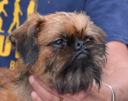

In [23]:
dest = 'images/brussels griffon.jpg'
download_url(imageURLs[2], dest)
image = Image.open(dest)
image.to_thumb(128, 128)

In [31]:
# !rm -rf breeds

In [32]:
dog_breeds = 'brussels griffon', 'chihuahua', 'havanese'
path = Path('breeds')
if not path.exists():
    path.mkdir()
    for breed in dog_breeds:
        dest = (path/breed)
        dest.mkdir(exist_ok=True)
        imageURLs = search_images_ddg(f'{breed} dog')
        download_images(dest, urls=imageURLs)

In [ ]:
filenames = get_image_files(path)
filenames

In [35]:
failed = verify_images(filenames)
len(failed)

7

In [36]:
failed.map(Path.unlink)

(#7) [None,None,None,None,None,None,None]

In [ ]:
# A DataBlock is a template for creating DataLoaders
dogs = DataBlock(
    # Dependent variable is an image, dependent variable is a category (breed)
    blocks=(ImageBlock, CategoryBlock),
    # Function to use for fetching image files (takes path argument)
    # The path argument is specified when we create an instance:
    #   dataloaders = dogs.dataloaders(path)
    get_items=get_image_files,
    # Use 20% of data selected randomly as validation set,
    # use the same 20% across runs by specifying seed
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # Use file's direcotry name as dependent variable
    get_y=parent_label,
    # To run images through model in paralell, they all must be of the same size
    item_tfms=Resize(128)
)

In [ ]:
dls = dogs.dataloaders(path)

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
# Randomly select a cropped portion of the image for each epoch
# Select at least 30% of the image
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
# aug_transforms provides standard set of data augmentations
# note that we switched back to Resize and did twice as much augmenting
# to make the output clearer for this example
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls=dogs.dataloaders(path)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=5)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/brussels griffon dog.jpg')

In [ ]:
learn_inf.dls.vocab

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_p1 = widgets.Output()
out_p1.clear_output()
with out_p1: display(img.to_thumb(128,128))
out_p1

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_p1.clear_output()
    with out_p1: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Upload a dog photo:'), btn_upload, btn_run, out_p1, lbl_pred])

In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

In [ ]:
!cp ./export.pkl gdrive/MyDrive/Colab\ Notebooks/Practical\ Deep\ Learning